In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import re
from collections import defaultdict

In [3]:
import sys
sys.path.append('../evaluation/')

In [4]:
from utils_eval import build_pdb_dict, get_minimized_affinity, get_affinity_best_pose

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [6]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [7]:
with open('selected_lig.txt', 'r') as f:
    selected_lig = f.read().splitlines()

selected_lig

['2bur_A_rec_1eoc_4nc_lig_tt_min_0',
 '4xud_A_rec_5lsa_dnc_lig_tt_docked_2',
 '2evs_A_rec_4h2z_mys_lig_tt_min_0',
 '5ehq_A_rec_1j06_ae3_lig_tt_min_0',
 '1oty_A_rec_3occ_dih_lig_tt_docked_18',
 '5uez_A_rec_5uev_88y_lig_tt_min_0',
 '5lvr_A_rec_5fe6_5wz_lig_tt_min_0',
 '5nu3_A_rec_5lpj_xdm_lig_tt_docked_5',
 '2xr9_A_rec_5ijs_5jk_lig_tt_min_0',
 '1otx_A_rec_4tti_fmc_lig_tt_min_0']

In [16]:
methods = {
    'PP2Drug': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/evaluation/structure_based/vp',
    # 'PP2Drug': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/evaluation/structure_based/vp',  # basic
    'Pocket2Mol': '/home2/conghao001/protein2drug/Pocket2Mol/outputs_selected_pdb',
    'TargetDiff': '/home2/conghao001/e3_mol_design/targetdiff/scripts/outputs_selected_pdb',
}

In [17]:
def get_ref_scores(raw_data_path=raw_data_path, selected_lig=selected_lig, pdb_rev_dict=pdb_rev_dict):
    ref_scores = []
    for lig in selected_lig:
        ligand_file = lig + '.sdf'
        pdb_folder = pdb_rev_dict[ligand_file]
        ref_file = os.path.join(raw_data_path, pdb_folder, ligand_file)
        ref_score = get_minimized_affinity(ref_file, 'ref')
        ref_scores.append(ref_score)

    return ref_scores

In [18]:
reference_scores = get_ref_scores()
reference_scores

[-5.39065,
 -6.05784,
 -8.0553,
 -2.73328,
 -6.83959,
 -6.19688,
 -5.45864,
 -6.95091,
 -10.10792,
 -6.31644]

In [19]:
def get_res(path, raw_data_path=raw_data_path, selected_lig=selected_lig, pdb_rev_dict=pdb_rev_dict, aromatic=True):
    score_dict = defaultdict(lambda : [])
    for lig in selected_lig:
        ligand_file = lig + '.sdf'
        pdb_folder = pdb_rev_dict[ligand_file]
        ref_file = os.path.join(raw_data_path, pdb_folder, ligand_file)
        ref_score = get_minimized_affinity(ref_file, 'ref')
        
        log_path = os.path.join(path, lig, 'logs_aromatic' if aromatic else 'logs')
        for fn in os.listdir(log_path):
            log_file = os.path.join(log_path, fn)
            gen_score, cnn_score = get_affinity_best_pose(log_file)
            # score_dict[lig].append([gen_score, cnn_score, ref_score])
            score_dict[lig].append(gen_score)

    return score_dict

In [20]:
ba_scores = {}
for method, path in methods.items():
    if 'Aromatic' in method:
        ba_scores[method] = get_res(path, aromatic=True)
    else:
        ba_scores[method] = get_res(path, aromatic=False)

In [21]:
ba_scores

{'PP2Drug': defaultdict(<function __main__.get_res.<locals>.<lambda>()>,
             {'2bur_A_rec_1eoc_4nc_lig_tt_min_0': [-6.43,
               -6.48,
               -6.48,
               -6.49,
               -6.46,
               -6.34,
               -6.78,
               -6.48,
               -6.47,
               -6.47,
               -6.46,
               -6.48,
               -6.44,
               -6.4,
               -6.39,
               -6.51,
               -6.39,
               -6.47,
               -6.48,
               -6.47,
               -6.51,
               -6.38,
               -6.37,
               -6.45,
               -6.48,
               -6.47,
               -6.39,
               -6.44,
               -6.49,
               -6.47,
               -6.42,
               -6.49,
               -6.46,
               -6.44,
               -6.5,
               -6.45,
               -6.44,
               -6.5,
               -6.48,
               -6.49,
              

In [22]:
all_df = {}
for method, score_dict in ba_scores.items():
    data = []
    for lig, scores in score_dict.items():
        pdb_id = lig[lig.rfind('rec')+4:lig.rfind('rec')+8].upper()
        data += [(score, pdb_id, method) for score in scores]
    all_df[method] = pd.DataFrame.from_records(data, columns=['Vina Score (kcal/mol)', 'PDB id', 'model'])

In [23]:
dfs = pd.concat([df for df in all_df.values()])
dfs

,Vina Score (kcal/mol),PDB id,model
0,-6.43,1EOC,PP2Drug
1,-6.48,1EOC,PP2Drug
2,-6.48,1EOC,PP2Drug
3,-6.49,1EOC,PP2Drug
4,-6.46,1EOC,PP2Drug
...,...,...,...
177,-10.29,4TTI,TargetDiff
178,-6.59,4TTI,TargetDiff
179,-6.16,4TTI,TargetDiff
180,-5.68,4TTI,TargetDiff


<Figure size 800x400 with 0 Axes>

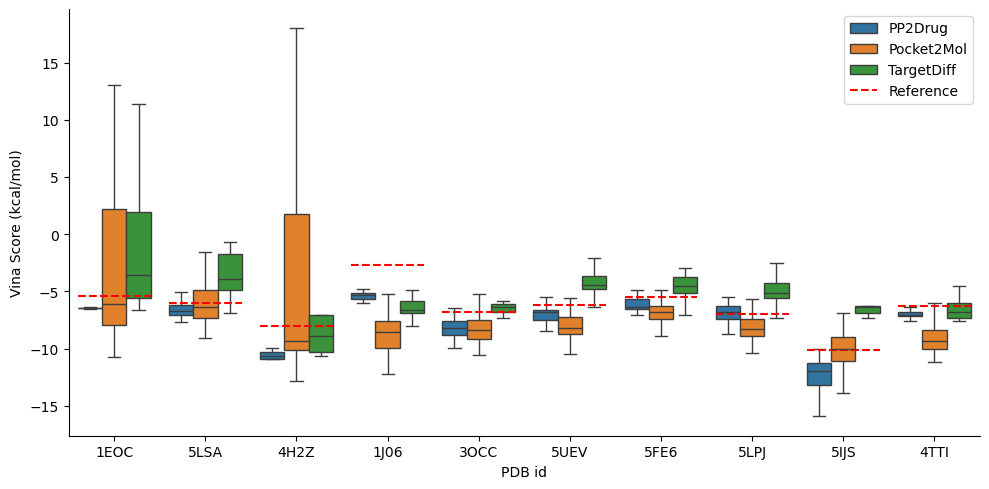

In [30]:
plt.figure(figsize=(8, 4))
box_plot = sns.catplot(data=dfs, x="PDB id", y="Vina Score (kcal/mol)", hue="model", kind="box", aspect=2, legend_out=False, showfliers=False)
for i, ref_score in enumerate(reference_scores):
    plt.axhline(y=ref_score, xmin=i / len(reference_scores) + 0.01, xmax=(i + 1) / len(reference_scores) - 0.01, 
                color='red', linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
custom_legend = [
    Line2D([0], [0], color='red', linestyle='--', label='Reference')
]
handles.extend(custom_legend)
labels.extend(['Reference'])
plt.legend(handles=handles, labels=labels)
plt.show()

In [31]:
box_plot.savefig('BA_dist.png', dpi=300)

In [37]:
res_dict = {}
for method, score_dict in ba_scores.items():
    data = []
    for lig, scores in score_dict.items():
        num_sample = len(scores)
        ligand_file = lig + '.sdf'
        pdb_folder = pdb_rev_dict[ligand_file]
        ref_file = os.path.join(raw_data_path, pdb_folder, ligand_file)
        ref_score = get_minimized_affinity(ref_file, 'ref')

        count = sum(1 for score in scores if score < ref_score)
        ratio = count / num_sample
        pdb_id = lig[lig.rfind('rec')+4:lig.rfind('rec')+8].upper()
        data.append([method, pdb_id, ratio, num_sample])
    # res_dict[method] = {
    #     'PDB ID': pdb_id,
    #     'High affinity ratio': ratio, 
    #     'Number of samples': num_sample
    # }
    res_dict[method] = pd.DataFrame.from_records(data, columns=['Model', 'PDB ID', 'High affinity ratio', 'Number of samples'])

In [38]:
high_ba_df = pd.concat([df for df in res_dict.values()])
# high_ba_df = high_ba_df.groupby('Model')
high_ba_df

,Model,PDB ID,High affinity ratio,Number of samples
0,PP2Drug,1EOC,0.990000,100
1,PP2Drug,5LSA,0.760000,100
2,PP2Drug,4H2Z,1.000000,100
3,PP2Drug,1J06,1.000000,100
4,PP2Drug,3OCC,0.930000,100
5,PP2Drug,5UEV,0.910000,100
6,PP2Drug,5FE6,0.800000,100
7,PP2Drug,5LPJ,0.480000,100
8,PP2Drug,5IJS,0.989899,99
9,PP2Drug,4TTI,0.990000,100


In [43]:
high_ba_df.loc[high_ba_df['Model']=='PP2Drug'][['PDB ID', 'High affinity ratio', 'Number of samples']]

,PDB ID,High affinity ratio,Number of samples
0,1EOC,0.990000,100
1,5LSA,0.760000,100
2,4H2Z,1.000000,100
3,1J06,1.000000,100
4,3OCC,0.930000,100
5,5UEV,0.910000,100
6,5FE6,0.800000,100
7,5LPJ,0.480000,100
8,5IJS,0.989899,99
9,4TTI,0.990000,100


In [46]:
def get_pp_match_res(path, method, raw_data_path=raw_data_path, selected_lig=selected_lig, pdb_rev_dict=pdb_rev_dict):
    score_dict = dict()
    for lig in selected_lig:
        if method.startswith('PP2Drug'):
            if 'Aromatic' in method:
                fn = 'aromatic_scores.csv'
            else:
                fn = 'basic_scores.csv'

        else:
            fn = lig + '_scores.csv'

        pdb_id = lig[lig.rfind('rec')+4:lig.rfind('rec')+8].upper()
        df = pd.read_csv(os.path.join(path, lig, fn), index_col=0, header=0)
        scores = df['score'].values
        avg_score = np.mean(scores)
        score_dict[pdb_id] = avg_score

    return score_dict

In [47]:
pp_scores = {}
for method, path in methods.items():
    pp_scores[method] = get_pp_match_res(path, method)

pp_scores

{'PP2Drug': {'1EOC': 0.7633333333333334,
  '5LSA': 0.7100000000000002,
  '4H2Z': 0.9090909090909094,
  '1J06': 1.0,
  '3OCC': 0.74,
  '5UEV': 0.8375,
  '5FE6': 1.0,
  '5LPJ': 0.8258333333333332,
  '5IJS': 0.9696969696969697,
  '4TTI': 0.9814285714285714},
 'Pocket2Mol': {'1EOC': 0.3365695792880259,
  '5LSA': 0.46296296296296297,
  '4H2Z': 0.49358974358974356,
  '1J06': 0.08333333333333333,
  '3OCC': 0.22222222222222224,
  '5UEV': 0.3942307692307692,
  '5FE6': 0.4543114543114542,
  '5LPJ': 0.41352201257861637,
  '5IJS': 0.3078029485796476,
  '4TTI': 0.36519607843137253},
 'TargetDiff': {'1EOC': 0.16666666666666666,
  '5LSA': 0.24691358024691357,
  '4H2Z': 0.37777777777777777,
  '1J06': 0.109375,
  '3OCC': 0.23809523809523814,
  '5UEV': 0.16761363636363635,
  '5FE6': 0.22767857142857137,
  '5LPJ': 0.17083333333333334,
  '5IJS': 0.13580246913580243,
  '4TTI': 0.19791666666666666}}

In [48]:
pp_df = pd.DataFrame.from_dict(pp_scores)
pp_df

,PP2Drug,Pocket2Mol,TargetDiff
1EOC,0.763333,0.336570,0.166667
5LSA,0.710000,0.462963,0.246914
4H2Z,0.909091,0.493590,0.377778
1J06,1.000000,0.083333,0.109375
3OCC,0.740000,0.222222,0.238095
5UEV,0.837500,0.394231,0.167614
5FE6,1.000000,0.454311,0.227679
5LPJ,0.825833,0.413522,0.170833
5IJS,0.969697,0.307803,0.135802
4TTI,0.981429,0.365196,0.197917
